In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py


In [3]:
#importing tensorflow w/o gpus
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [4]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)

var_levels = Ventral_Dataset['image_meta']['variation_level'][:] 

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]

num_neurons = Neural_Data.shape[1]
num_categories = 8 

In [5]:
categories[:10]

array(['Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits',
       'Fruits', 'Fruits', 'Fruits', 'Fruits'],
      dtype='|S7')

In [6]:
#we'll construct 8 one-vs-all vectors with {-1, 1} values
category_matrix = np.array([2 * (categories == c) - 1 for 
                             c in unique_categories]).T.astype(int)

In [7]:
category_matrix[0]

array([-1, -1, -1, -1, -1,  1, -1, -1])

In [8]:
sess = tf.Session()

In [9]:
# as previously seen in lecture 8 we'll set up a hinge loss

#first, get initializers for W and b
initial_weights = tf.random_uniform(shape=(num_neurons, num_categories),
                  minval=-1,
                  maxval=1,
                  seed=0)

initial_bias = tf.zeros(shape=(num_categories,))

In [10]:
#now construct the TF variables
weights = tf.get_variable('weights', 
                           dtype=tf.float32,
                           initializer=initial_weights)
                         
bias = tf.get_variable('bias', 
                       dtype=tf.float32,
                       initializer=initial_bias)

In [11]:
#initialize variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [12]:
#input slots for data and labels
#note the batch size is "None" -- effectively meaning batches of 
#varying sizes can be used
neural_data = tf.placeholder(shape=(None, num_neurons),
                              dtype=tf.float32)

category_labels = tf.placeholder(shape=(None, num_categories),
                                 dtype=tf.float32)

In [13]:
#now construct margins
margins = tf.matmul(neural_data, weights) + bias

#the hinge loss
hinge_loss = tf.maximum(0., 1. - category_labels * margins)

#and take the mean of the loss over the batch
hinge_loss_mean = tf.reduce_mean(hinge_loss)

In [14]:
#simple interface for using tensorflow built-in optimizer
#as seen yesterclass

def tf_optimize(loss,
                optimizer_class,
                target,
                training_data,
                num_iterations,
                optimizer_args=(),
                optimizer_kwargs=None,
                sess=None,
                initial_guesses=None):
                           
    if sess is None:
        sess = tf.Session()
        
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    
    #construct the optimizer
    optimizer = optimizer_class(*optimizer_args, 
                                **optimizer_kwargs)
    optimizer_op = optimizer.minimize(loss)
    
    #initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    if initial_guesses is not None:
        for k, v in initial_guesses.items():
            op = tf.assign(k, v)
            sess.run(op)

    targetvals = []
    losses = []
    times = []
    for i in range(num_iterations):
        t0 = time.time()
        output = sess.run({'opt': optimizer_op,
                           'target': target,
                           'loss': loss}, 
                           feed_dict=training_data)
        times.append(time.time() - t0)
        targetvals.append(output['target'])
        losses.append(output['loss'])
    
    print('Average time per iteration --> %.5f' % np.mean(times))
    return np.array(losses), targetvals

In [15]:
#let's just focus on one batch of data for the moment

batch_size = 640
data_batch = Neural_Data[0: batch_size]
label_batch = category_matrix[0: batch_size]

data_dict = {neural_data: data_batch,
             category_labels: label_batch}

('weights shape:', (296, 8))
('biases:', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))


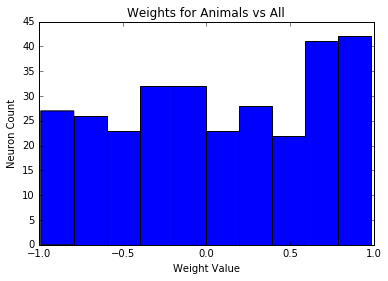

In [16]:
#let's look at the weights and biases before training
weight_vals, bias_vals = sess.run([weights, bias])

#right, it's num_neurons x num_categories
print('weights shape:', weight_vals.shape)

#let's look at some of the weights
plt.hist(weight_vals[:, 0])
plt.xlabel('Weight Value')
plt.ylabel('Neuron Count')
plt.title('Weights for Animals vs All')

print('biases:', bias_vals)

In [17]:
#ok so we'll use the Momentum optimizer to find weights and bias
#for this classification problem
losses, targs = tf_optimize(loss=hinge_loss_mean,
            optimizer_class=tf.train.MomentumOptimizer,
            target=[],
            training_data=data_dict,
            num_iterations=100,
            optimizer_kwargs={'learning_rate': 1, 'momentum': 0.9},
            sess=sess)

Average time per iteration --> 0.00128


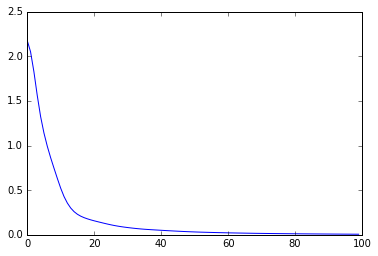

In [18]:
#losses decrease almost to 0
plt.plot(losses)

('biases:', array([-5.6579237 , -5.38999081, -6.01903248, -5.87763357, -5.83938694,
       -5.5426507 , -5.03545904, -5.47604179], dtype=float32))


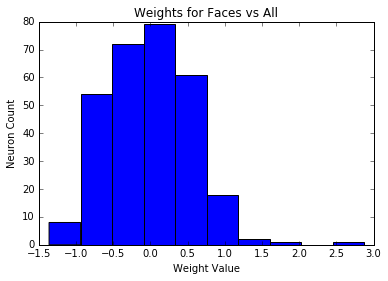

In [19]:
weight_vals, bias_vals = sess.run([weights, bias])

#right, it's num_neurons x num_categories
weight_vals.shape

#let's look at some of the weights
plt.hist(weight_vals[:, 2])
plt.xlabel('Weight Value')
plt.ylabel('Neuron Count')
plt.title('Weights for Faces vs All')

print('biases:', bias_vals)

#ok so things have been learned!

In [20]:
#how good are the results on training? 

#actually get the predictions by first getting the margins
margin_vals = sess.run(margins, feed_dict = data_dict)
#now taking the argmax across categories
pred_inds = margin_vals.argmax(axis=1)
#compare prediction to actual
correct = pred_inds == label_batch.argmax(axis=1)
pct = correct.sum() / float(len(correct)) * 100
print('Training accuracy: %.2f%%' % pct)

#Right, very accurate on training

Training accuracy: 99.53%


### Stochastic Gradient Descent

In [21]:
class BatchReader(object):
    
    def __init__(self, data_dict, batch_size, shuffle=True, shuffle_seed=0, pad=True):
        self.data_dict = data_dict        
        self.batch_size = batch_size
        _k = data_dict.keys()[0]
        self.data_length = data_dict[_k].shape[0]
        self.total_batches = (self.data_length - 1) // self.batch_size + 1
        self.curr_batch_num = 0
        self.curr_epoch = 1
        self.pad = pad
        self.shuffle = shuffle
        self.shuffle_seed = shuffle_seed
        
        if self.shuffle:
            self.rng = np.random.RandomState(seed=self.shuffle_seed)
            self.perm = self.rng.permutation(self.data_length)
        
    def __iter__(self):
        return self

    def next(self):
        return self.get_next_batch()
        
    def get_next_batch(self):
        data = self.get_batch(self.curr_batch_num)
        self.increment_batch_num()
        return data

    def increment_batch_num(self):
        m = self.total_batches
        if (self.curr_batch_num >= m - 1):
            self.curr_epoch += 1
            if self.shuffle:
                self.perm = self.rng.permutation(self.data_length)
        self.curr_batch_num = (self.curr_batch_num + 1) % m

    def get_batch(self, cbn):
        data = {}
        startv = cbn * self.batch_size
        endv = (cbn + 1) * self.batch_size
        if self.pad and endv > self.data_length:
            startv = self.data_length - self.batch_size
            endv = startv + self.batch_size
        for k in self.data_dict:
            if self.shuffle:
                data[k] = self.data_dict[k][self.perm[startv: endv]]
            else:
                data[k] = self.data_dict[k][startv: endv]
        return data


In [22]:
class TF_Optimizer(object):
    """Make the tensorflow SGD-style optimizer into a scikit-learn compatible class
       Uses BatchReader for stochastically getting data batches.
       
       model_func: function which returns tensorflow nodes for
                     predictions, data_input
        
       loss_func: function which takes model_func prediction output node and 
                  returns tensorflow nodes for
                     loss, label_input
                     
       optimizer_class: which tensorflow optimizer class to when learning the model parameters
       
       batch_size: which batch size to use in training
       
       train_iterations: how many iterations to run the optimizer for 
           --> this should really be picked automatically by like when the training
               error plateaus
               
        model_kwargs:  dictionary of additional arguments for the model_func
        
        loss_kwargs: dictionary of additional arguments for the loss_func
        
        optimizer_args, optimizer_kwargs: additional position and keyword args for the
         optimizer class
         
        sess: tf session to use (will be constructed if not passed) 
        
        train_shuffle: whether to shuffle example order during training
       
    """ 
    
    def __init__(self, 
                 model_func,
                 loss_func, 
                 optimizer_class,
                 batch_size,
                 train_iterations,
                 model_kwargs=None,
                 loss_kwargs=None,
                 optimizer_args=(),
                 optimizer_kwargs=None,
                 sess=None,
                 train_shuffle=False
                 ):
                        
        self.model_func = model_func
        if model_kwargs is None:
            model_kwargs = {}
        self.model_kwargs = model_kwargs
        self.loss_func = loss_func
        if loss_kwargs is None:
            loss_kwargs = {}
        self.loss_kwargs = loss_kwargs
        self.train_shuffle=train_shuffle
        
        self.train_iterations = train_iterations
        self.batch_size = batch_size
     
        if sess is None:
            sess = tf.Session()
        self.sess = sess
                
        if optimizer_kwargs is None:
            optimizer_kwargs = {}
        self.optimizer = optimizer_class(*optimizer_args, 
                                         **optimizer_kwargs)
        
    def fit(self, train_data, train_labels):
        self.model, self.data_holder = self.model_func(**self.model_kwargs)
        self.loss, self.labels_holder = self.loss_func(self.model, **self.loss_kwargs)
        
        self.optimizer_op = self.optimizer.minimize(self.loss)
            
        data_dict = {self.data_holder: train_data,
                     self.labels_holder: train_labels}
        train_data = BatchReader(data_dict=data_dict,
                                 batch_size=self.batch_size,
                                 shuffle=self.train_shuffle,
                                 shuffle_seed=0,
                                 pad=True)
        
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
        self.losses = []                      
        for i in range(self.train_iterations):
            data_batch = train_data.next()
            output = self.sess.run({'opt': self.optimizer_op,
                                    'loss': self.loss}, 
                                    feed_dict=data_batch)
            self.losses.append(output['loss'])
                
    def predict(self, test_data):
        data_dict = {self.data_holder: test_data}
        test_data = BatchReader(data_dict=data_dict,
                             batch_size=self.batch_size,
                             shuffle=False,
                             pad=False)                  
        preds = []
        for i in range(test_data.total_batches):
            data_batch = test_data.get_batch(i)
            pred_batch = self.sess.run(self.model, feed_dict=data_batch)
            preds.append(pred_batch)
        return np.row_stack(preds)


In [23]:
def binarize_labels(labels):
    """takes discrete-valued labels and binarizes them into {-1, 1}-value format
       returns:
           binarized_labels: of shape (num_stimuli, num_categories)
           unique_labels: actual labels indicating order of first axis in binarized_labels
    """
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    binarized_labels = np.array([2 * (labels == c) - 1 for 
                                    c in unique_labels]).T.astype(int)
    return binarized_labels, unique_labels
    

class TF_OVA_Classifier(TF_Optimizer):
    """
    Subclass of TFOptimizer for use with categorizers. Basically, this class 
    handles data binarization (in the fit method) and un-binarization 
    (in the predict method), so that we can use the class with the function:
    
         train_and_test_scikit_classifier
    
    that we've previously defined. 
    
    The predict method here implements a one-vs-all approach for multi-class problems.
    """
    
    def fit(self, train_data, train_labels):
        #binarize labels
        num_features = train_data.shape[1]
        binarized_labels, classes_ = binarize_labels(train_labels)
        #set .classes_ attribute, since this is needed by train_and_test_scikit_classifier
        self.classes_ = classes_
        num_classes = len(classes_)
        #pass number of features and classes to the model construction 
        #function that will be called when the fit method is called
        self.model_kwargs['num_features'] = num_features
        self.model_kwargs['num_classes'] = num_classes
        #now actually call the optimizer fit method
        TF_Optimizer.fit(self, train_data=train_data, 
                              train_labels=binarized_labels)
  
    def decision_function(self, test_data):
        #returns what are effectively the margins (for a linear classifier)
        return TF_Optimizer.predict(self, test_data)
    
    def predict(self, test_data):
        #use the one-vs-all rule for multiclass prediction. 
        preds = self.decision_function(test_data)
        preds = np.argmax(preds, axis=1)
        classes_ = self.classes_
        return classes_[preds]

In [24]:
def linear_classifier(num_features, num_classes):
    """generic form of a linear classifier, e.g. the model
          margins = np.dot(data, weight) + bias
    """
    initial_weights = tf.zeros(shape=(num_features, 
                                      num_classes), 
                               dtype=tf.float32)
    weights = tf.Variable(initial_weights, 
                          dtype=tf.float32,
                          name='weights')
    initial_bias = tf.zeros(shape=(num_classes,))
    bias = tf.Variable(initial_bias, 
                       dtype=tf.float32,
                       name='bias')
                           
    data = tf.placeholder(shape=(None, num_features), dtype=tf.float32, name='data')
    margins = tf.add(tf.matmul(data, weights), bias, name='margins')
    return margins, data


def hinge_loss(margins):
    """standard SVM hinge loss
    """
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1. - category_labels * margins, name='hinge_loss')
    hinge_loss_mean = tf.reduce_mean(h, name='hinge_loss_mean')
    return hinge_loss_mean, category_labels

In [140]:
#construct the classifier instance ... just like with scikit-learn
cls = TF_OVA_Classifier(model_func=linear_classifier,
              loss_func=hinge_loss, 
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess
              )

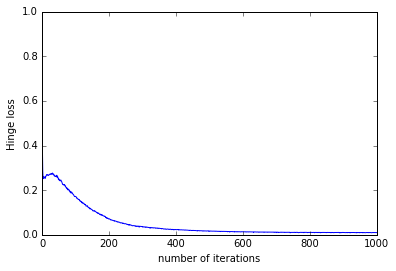

In [141]:
#ok let's try out our classifier on medium-variation data
data_subset = Neural_Data[var_levels=='V3']
categories_subset = categories[var_levels=='V3']

cls.fit(data_subset, categories_subset)

plt.plot(cls.losses)
plt.xlabel('number of iterations')
plt.ylabel('Hinge loss')

In [142]:
#ok how good was the actual training accuracy? 
preds = cls.predict(data_subset)
acc = (preds == categories_subset).sum()
pct = acc / float(len(preds)) * 100

print('Training accuracy was %.2f%%' % pct)

Training accuracy was 99.77%


#### Side note on getting relevant tensors

In [114]:
#here's the linear mode constructed above:
lin_model = cls.model
print(lin_model)

Tensor("margins_168:0", shape=(?, 8), dtype=float32)


In [125]:
#suppose we want to access the weights / bias used in this model?
#these can be accessed by the "op.inputs" attribute in TF

#first, we see that this is the stage of the caluation
#where the linear model (the margins) is put together by adding 
#the result of the matrix multiplication ("MatMul_[somenumber]")
#to the bias
list(lin_model.op.inputs)

[<tf.Tensor 'MatMul_169:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'bias_169/read:0' shape=(8,) dtype=float32>]

In [132]:
#so bias is just the first of these inputs
bias_tensor = lin_model.op.inputs[1]
bias_tensor

<tf.Tensor 'bias_169/read:0' shape=(8,) dtype=float32>

In [130]:
#if we follow up the calculation graph by taking apart
#whatever was the inputs to the matmul stage, we see
#the data and the weights
matmul_tensor = lin_model.op.inputs[0]
list(matmul_tensor.op.inputs)

[<tf.Tensor 'data_168:0' shape=(?, 296) dtype=float32>,
 <tf.Tensor 'weights_169/read:0' shape=(296, 8) dtype=float32>]

In [131]:
#so the weights tensor is just the first of *these* inputs
weights_tensor = matmul_tensor.op.inputs[1]
weights_tensor

<tf.Tensor 'weights_169/read:0' shape=(296, 8) dtype=float32>

In [134]:
#putting this together, we could have done:
weights_tensor = lin_model.op.inputs[0].op.inputs[1]
weights_tensor

<tf.Tensor 'weights_169/read:0' shape=(296, 8) dtype=float32>

#### Regularization

In [135]:
#we can define other loss functions -- such as L2 regularization

def hinge_loss_l2reg(margins, C, square=False):
    #starts off the same as regular hinge loss
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1 - category_labels * margins)
    #allows for squaring the hinge_loss optionally, as done in sklearn
    if square:
        h = h**2
    hinge_loss = tf.reduce_mean(h)
    
    #but how let's get the weights from the margins,
    #using the method just explored above
    weights = margins.op.inputs[0].op.inputs[1]
    #and get sum-square of the weights -- the 0.5 is for historical reasons
    reg_loss = 0.5*tf.reduce_mean(weights**2) 
    
    #total up the loss from the two terms with constant C for weighting 
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss, category_labels

In [138]:
cls = TF_OVA_Classifier(model_func=linear_classifier,
              loss_func=hinge_loss_l2reg, 
              loss_kwargs={'C':1},
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess,
              )

Regularized training accuracy was 93.87%


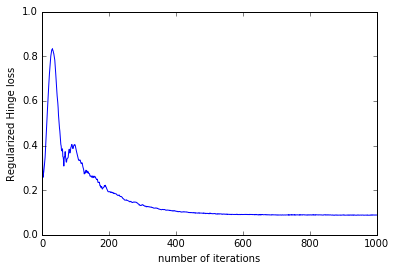

In [139]:
data_subset = Neural_Data[var_levels=='V3']
categories_subset = categories[var_levels=='V3']

cls.fit(data_subset, categories_subset)

plt.plot(cls.losses)
plt.xlabel('number of iterations')
plt.ylabel('Regularized Hinge loss')

preds = cls.predict(data_subset)
acc = (preds == categories_subset).sum()
pct = acc / float(len(preds)) * 100

print('Regularized training accuracy was %.2f%%' % pct)

#unsuprisingly training accuracy goes down a bit with regularization
#compared to before w/o regularization

### Integrating with cross validation tools

In [31]:
import cross_validation as cv

In [32]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

In [102]:
#the whole point of creating the TF_OVA_Classifier above
#was that we could simply stick it into the cross-validation regime
#that we'd previously set up for scikit-learn style classifiers
#so now let's test it out

#create some train/test splits
splits = cv.get_splits(meta_array, 
              lambda x: x['object_name'],  #we're balancing splits by object
              5,  
              5,  
              35,  
              train_filter=lambda x: (x['variation_level'] == 'V3'),
              test_filter=lambda x: (x['variation_level'] == 'V3'),)
    
    
#here are the arguments to the classifier
model_args = {'model_func': linear_classifier,
              'model_kwargs': {},
              'loss_func': hinge_loss_l2reg, 
              'loss_kwargs': {'C':5e-2, #<-- a good regularization value
                             },   
              'batch_size': 2500,
              'train_iterations': 1000,  #<-- about the right number of steps
              'train_shuffle': True,
              'optimizer_class':tf.train.MomentumOptimizer,
              'optimizer_kwargs': {'learning_rate':.1,
                                   'momentum': 0.9},
              'sess': sess}

#so now it should work just like before
res = cv.train_and_test_scikit_classifier(features=Neural_Data,
                                       labels=categories,
                                       splits=splits,
                                       model_class=TF_OVA_Classifier,
                                       model_args=model_args)


In [103]:
#yep!
res[0]['test']['mean_accuracy']

0.86062500000000008

#### Logistic Regression with Softmax loss 

In [72]:
def softmax_loss_l2reg(margins, C):
    """this shows how to write softmax logistic regression 
       using tensorflow
    """
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    
    #get the softmax from the margins
    probs = tf.nn.softmax(margins) 
    #extract just the prob value for the correct category
    #(we have the (cats + 1)/2 thing because the category_labels
    #come in as {-1, +1} values but we need {0,1} for this purpose)
    probs_cat_vec = probs * ((category_labels + 1.) / 2.)
    #sum up over categories (actually only one term, that for
    #the correct category, contributes on each row)
    probs_cat = tf.reduce_mean(probs_cat_vec, axis=1)
    #-log 
    neglogprob = -tf.log(probs_cat)
    #average over the batch
    log_loss = tf.reduce_mean(neglogprob)
    
    weights = cls.model.op.inputs[0].op.inputs[1]
    reg_loss = 0.5*tf.reduce_mean(tf.square(weights)) 
    
    total_loss = C * log_loss + reg_loss
    return total_loss, category_labels

In [97]:
model_args={'model_func': linear_classifier,
            'model_kwargs': {},
            'loss_func': softmax_loss_l2reg, 
            'loss_kwargs': {'C': 5e-3},
            'batch_size': 2500,
            'train_iterations': 1000,
            'train_shuffle': True,
            'optimizer_class':tf.train.MomentumOptimizer,
            'optimizer_kwargs': {'learning_rate': 1.,
                                 'momentum': 0.9
                                 },
            'sess': sess}

res = cv.train_and_test_scikit_classifier(features=Neural_Data,
                                       labels=categories,
                                       splits=splits,
                                       model_class=TF_OVA_Classifier,
                                       model_args=model_args)


In [98]:
res[0]['test']['mean_accuracy']
#ok works reasonably well

0.85437499999999988